
# Amazon Forecast: predicting time-series at scale

Forecasting is used in a variety of applications and business use cases: 

For example, 
- Retailers need to forecast the sales of their products to decide how much stock they need by location, 
- Manufacturers need to estimate the number of parts required at their factories to optimize their supply chain, 
- Businesses need to estimate their flexible workforce needs, 
- Utilities need to forecast electricity consumption needs in order to attain an efficient energy network, and 
- Enterprises need to estimate their cloud infrastructure needs.


## Table of Contents

* Step 0: Setting up
* Step 1: Preparing the Datasets
* Step 2: Importing the Data
    * Step 2a: Creating a Target Dataset
    * Step 2b: Creating a Related Dataset
    * Step 2c: Update the Dataset Group
    * Step 2d: Creating a Target Time Series Dataset Import Job
    * Step 2fe: Creating a Item Metadata Dataset Import Job
* Step 3: Choosing an Algorithm and Evaluating its Performance
* Step 4: Computing Error Metrics from Backtesting
* Step 5: Creating a Forecast
* Step 6: Querying the Forecasts
* Step 7: Exporting the Forecasts
* Step 8: Cleaning up your Resources

### Step 0: Setting up
This section sets up the permissions and relevant endpoints.

In [1]:
#!pip install boto3 pandas matplotlib wget statsmodels
#!conda install -c anaconda boto3

In [2]:
import sys
import os

import boto3
import botocore.exceptions
import pandas as pd
import matplotlib.pyplot as plt
import time
import json
import gzip
import wget
import utils

Configure the S3 bucket name and region name for this lesson.

In [3]:
region = boto3.Session().region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')

# create unique S3 bucket for saving your own data
bucket_name = account_id + '-bh-retail-forecast'
if utils.create_bucket(bucket_name, region=region):
    print(f"Success! Created bucket {bucket_name}")

An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.


In [4]:
session = boto3.Session(region_name=region) 
s3 = session.client(service_name='s3')
forecast = session.client(service_name='forecast') 
forecastquery = session.client(service_name='forecastquery')

In [5]:
print("Creating Role for accesssing Amazon Forecast and S3")
# Create the role to provide to Amazon Forecast.
role_name = "ForecastNotebookRole-ItemMetadata"
role_arn = utils.get_or_create_iam_role( role_name = role_name )

Creating Role for accesssing Amazon Forecast and S3
The role ForecastNotebookRole-ItemMetadata exists, ignore to create it
Done.


The last part of the setup process is to validate that your account can communicate with Amazon Forecast, the cell below does just that.

In [6]:
# check you can communicate with Forecast API session
forecast.list_predictors()

{'Predictors': [],
 'ResponseMetadata': {'RequestId': 'a0d9ad1d-8458-409e-bd7f-f271c5560242',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 21 Sep 2021 15:57:21 GMT',
   'x-amzn-requestid': 'a0d9ad1d-8458-409e-bd7f-f271c5560242',
   'content-length': '17',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

# Step 1: Preparing the Datasets

https://www.kaggle.com/c/rossmann-store-sales/data?select=store.csv

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

In [7]:
sales_file = './data/sales data-set.csv'
store_file = './data/stores data-set.csv'

The following are descriptions for those that aren't.

- Id - an Id that represents a (Store, Date) duple within the test set
Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [8]:
sales_data = pd.read_csv(sales_file,parse_dates=["Date"],dtype='object')
sales_data.head(5)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [9]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  object        
 1   DayOfWeek      1017209 non-null  object        
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  object        
 4   Customers      1017209 non-null  object        
 5   Open           1017209 non-null  object        
 6   Promo          1017209 non-null  object        
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  object        
dtypes: datetime64[ns](1), object(8)
memory usage: 69.8+ MB


In [10]:
store_data = pd.read_csv(store_file)
store_data.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [11]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [12]:
sales_data.info()
print(f" Sales  Date range : {sales_data['Date'].min()}  to {sales_data['Date'].max()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  object        
 1   DayOfWeek      1017209 non-null  object        
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  object        
 4   Customers      1017209 non-null  object        
 5   Open           1017209 non-null  object        
 6   Promo          1017209 non-null  object        
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  object        
dtypes: datetime64[ns](1), object(8)
memory usage: 69.8+ MB
 Sales  Date range : 2013-01-01 00:00:00  to 2015-07-31 00:00:00


In [13]:
sales_data[["Store","DayOfWeek","Sales", "Customers","Open","Promo","SchoolHoliday"]] = \
        sales_data[["Store","DayOfWeek","Sales", "Customers","Open","Promo","SchoolHoliday"]].apply(pd.to_numeric)
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [14]:
max_sales = sales_data.loc[:,["Store","Sales"]].groupby("Store").sum()
prim_store = max_sales.index[max_sales["Sales"].argmax()]

In [15]:
prim_store

262

### Visualizing Sales Data

In [16]:
store1_sales_data = sales_data[(sales_data['Store']==prim_store) & (sales_data['Open']==1)]
store1_sales_data.info()
store1_sales_data.tail(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 261 to 1016356
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Store          942 non-null    int64         
 1   DayOfWeek      942 non-null    int64         
 2   Date           942 non-null    datetime64[ns]
 3   Sales          942 non-null    int64         
 4   Customers      942 non-null    int64         
 5   Open           942 non-null    int64         
 6   Promo          942 non-null    int64         
 7   StateHoliday   942 non-null    object        
 8   SchoolHoliday  942 non-null    int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 73.6+ KB


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1014126,262,4,2013-01-03,16616,2943,1,0,0,1
1015241,262,3,2013-01-02,16964,3113,1,0,0,1
1016356,262,2,2013-01-01,17267,2875,1,0,a,1


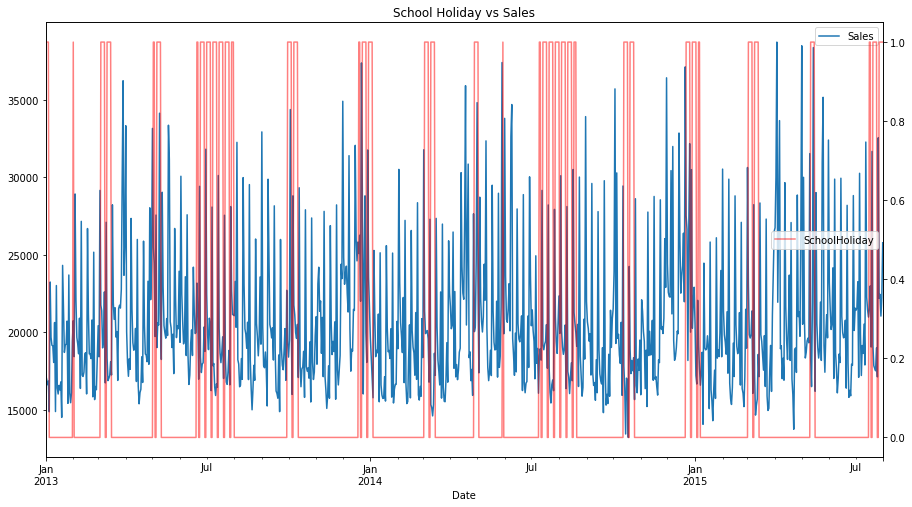

In [17]:
plt.figure(figsize=(15, 8))
plt.title('School Holiday vs Sales')
ax = plt.gca()
store1_sales_data.plot(x='Date', y='Sales', ax=ax);
ax2 = ax.twinx()
store1_sales_data.plot(x='Date', y='SchoolHoliday', color='red', ax=ax2,alpha=0.5);

In [18]:
sales_store_df = sales_data[(sales_data['Store']==prim_store) & (sales_data['Open']==1)]
sales_store_df = sales_store_df.set_index("Date")
sales_store_df = sales_store_df["Sales"]
sales_store_df.head(10)

Date
2015-07-31    25774
2015-07-30    22253
2015-07-29    21041
2015-07-28    22442
2015-07-27    22185
2015-07-26    32547
2015-07-25    17118
2015-07-24    18985
2015-07-23    17513
2015-07-22    17663
Name: Sales, dtype: int64

<AxesSubplot:title={'center':'Seasonality'}, xlabel='Date'>

<Figure size 1080x576 with 0 Axes>

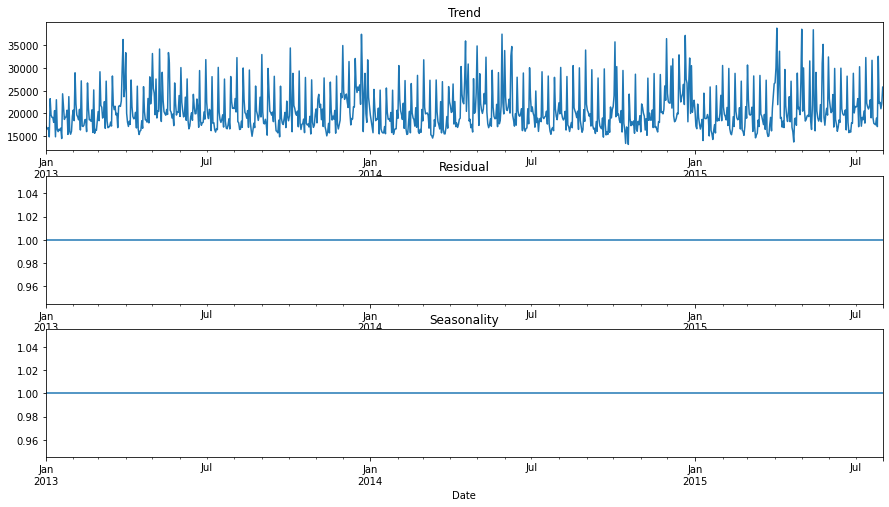

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(15, 8))
result = seasonal_decompose(sales_store_df, model='multiplicative', period=1)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
ax1.set_title('Trend')
result.trend.plot(ax=ax1,)
ax2.set_title('Residual')
result.resid.plot(ax=ax2)
ax3.set_title('Seasonality')
result.seasonal.plot(ax=ax3)

## Step 2a: Prepare and Save the Target Time Series

In [20]:
# what is your forecast horizon in number time units you've selected?
# e.g. if you're forecasting in hours, how many months out do you want a forecast?
FORECAST_LENGTH = 7

# What is your forecast time unit granularity?
# Choices are: ^Y|M|W|D|H|30min|15min|10min|5min|1min$ 
DATASET_FREQUENCY = "D"
TIMESTAMP_FORMAT = "yyyy-MM-dd"
# delimiter = ','

# What name do you want to give this project?  
# We will use this same name for your Forecast Dataset Group name.
PROJECT = 'rossmann_store_sales'
DATA_VERSION = 2

In [21]:
#renaming columns
target_tts_df = sales_data[sales_data['Store']==prim_store].rename(columns={"Store":"item_id","Date":"datetime","Sales":"count"})

In [22]:
target_tts_df = target_tts_df[['item_id', 'datetime', 'count']][:-FORECAST_LENGTH]
target_tts_df.reset_index(drop=True)

,item_id,datetime,count
0,262,2015-07-31,25774
1,262,2015-07-30,22253
2,262,2015-07-29,21041
3,262,2015-07-28,22442
4,262,2015-07-27,22185
...,...,...,...
930,262,2013-01-12,14880
931,262,2013-01-11,20625
932,262,2013-01-10,18047
933,262,2013-01-09,19113


## Step 2b: Prepare and Save the Related Time Series 

To use the related time series, we need to ensure that the related time series covers the whole target time series, as well as the future values as specified by the forecast horizon. More precisely, we need to make sure:

> len(related time series) >= len(target time series) + forecast horizon

Basically, all items need to have data start at or before the item start date, and have data until the forecast horizon (i.e. the latest end date across all items + forecast horizon). Additionally, there should be no missing values in the related time series. The following picture illustrates the desired logic.

In [23]:
rts_df =  sales_data[sales_data['Store']==prim_store].rename(columns={"Store":"item_id","Date":"datetime","Promo":"promo",'Open':'open'})
rts_df = rts_df[['item_id', 'datetime', 'promo','open']]
rts_df.tail(3)

,item_id,datetime,promo,open
1014126,262,2013-01-03,0,1
1015241,262,2013-01-02,0,1
1016356,262,2013-01-01,0,1


As we can see, the length of the related time series is equal to the length of the target time series plus the forecast horizon.

In [24]:
print(f"{len(target_tts_df)} + {FORECAST_LENGTH} = {len(rts_df)}")
assert len(target_tts_df) + FORECAST_LENGTH == len(rts_df), "length doesn't match"

935 + 7 = 942


Next we check whether there are "holes" in the related time series.

In [25]:
ls = list(rts_df['datetime'])
ls.sort()
assert len(rts_df) == len(pd.date_range(
    start=ls[0],
    end=ls[-1],
    freq='D'
))*rts_df["item_id"].nunique(), "missing entries in the related time series"

In [26]:
target_tts_df.to_csv(f"data/rossmann_store_{prim_store}_tts.csv", index= False, header = False)
rts_df.to_csv(f"data/rossmann_store_{prim_store}_rts.csv", index= False, header = False)

At this time the data is ready to be sent to S3 where Forecast will use it later. The following cells will upload the data to S3.

In [27]:
key = "rossmann_store"

s3.upload_file(Filename=f"data/rossmann_store_{prim_store}_tts.csv", Bucket = bucket_name, Key = f"{key}/{prim_store}.csv")
s3.upload_file(Filename=f"data/rossmann_store_{prim_store}_rts.csv", Bucket = bucket_name, Key = f"{key}/{prim_store}_rts.csv")

## Step 3: Create the Dataset Group and Dataset

First let's create a dataset group and then update it later to add our datasets.

In Amazon Forecast , a dataset is a collection of file(s) which contain data that is relevant for a forecasting task. A dataset must conform to a schema provided by Amazon Forecast. Since data files are imported headerless, it is important to define a schema for your data.

For this example, we are using RETAIL domain with 3 required attributes timestamp, target_value and item_id.

### Create the Dataset Group

In this task, we define a container name or Dataset Group name, which will be used to keep track of Dataset import files, schema, and all Forecast results which go together

In [28]:
dataset_group = f"{PROJECT}_{DATA_VERSION}"
print(f"Dataset Group Name = {dataset_group}")

Dataset Group Name = rossmann_store_sales_2


In [29]:
dataset_arns = []

create_dataset_group_response = \
    forecast.create_dataset_group(Domain="RETAIL",
                                  DatasetGroupName=dataset_group,
                                  DatasetArns=dataset_arns)

In [30]:
dataset_group_arn = create_dataset_group_response['DatasetGroupArn']

In [31]:
forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn)

{'DatasetGroupName': 'rossmann_store_sales_2',
 'DatasetGroupArn': 'arn:aws:forecast:ap-south-1:843203996641:dataset-group/rossmann_store_sales_2',
 'DatasetArns': [],
 'Domain': 'RETAIL',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2021, 9, 21, 21, 27, 29, 282000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2021, 9, 21, 21, 27, 29, 282000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'c20f824b-5b0b-48c3-a183-69e48927fa55',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 21 Sep 2021 15:57:29 GMT',
   'x-amzn-requestid': 'c20f824b-5b0b-48c3-a183-69e48927fa55',
   'content-length': '268',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

### Create the Target Schema

In [32]:
# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
ts_schema ={
   "Attributes":[
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      },
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"demand",
         "AttributeType":"float"
      }
   ]
}

### Create a Target Dataset

In [33]:
ts_dataset_name = f"{PROJECT}_{DATA_VERSION}_tts"
print(ts_dataset_name)

rossmann_store_sales_2_tts


In [34]:
response = \
    forecast.create_dataset(Domain="RETAIL",
                            DatasetType='TARGET_TIME_SERIES',
                            DatasetName=ts_dataset_name,
                            DataFrequency=DATASET_FREQUENCY,
                            Schema=ts_schema
                           )

In [35]:
ts_dataset_arn = response['DatasetArn']

In [36]:
forecast.describe_dataset(DatasetArn=ts_dataset_arn)

{'DatasetArn': 'arn:aws:forecast:ap-south-1:843203996641:dataset/rossmann_store_sales_2_tts',
 'DatasetName': 'rossmann_store_sales_2_tts',
 'Domain': 'RETAIL',
 'DatasetType': 'TARGET_TIME_SERIES',
 'DataFrequency': 'D',
 'Schema': {'Attributes': [{'AttributeName': 'item_id',
    'AttributeType': 'string'},
   {'AttributeName': 'timestamp', 'AttributeType': 'timestamp'},
   {'AttributeName': 'demand', 'AttributeType': 'float'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2021, 9, 21, 21, 27, 29, 488000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2021, 9, 21, 21, 27, 29, 488000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'e5349673-d71c-4b3f-823c-9ed8a7cc485a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 21 Sep 2021 15:57:28 GMT',
   'x-amzn-requestid': 'e5349673-d71c-4b3f-823c-9ed8a7cc485a',
   'content-length': '508',
   'connection': 'keep-alive'},
  'Ret

### Create the Related Schema

In [37]:
# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
rts_schema ={
   "Attributes":[
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      },
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"promo",
         "AttributeType":"integer"
      },
      {
         "AttributeName":"working",
         "AttributeType":"integer"
      }
   ]
}

### Create a Related Dataset
In this example, we will define a related time series.

In [56]:
rts_dataset_name = f"{PROJECT}_{DATA_VERSION}_rts"
print(rts_dataset_name)

rossmann_store_sales_2_rts


In [57]:
response = \
    forecast.create_dataset(Domain="RETAIL",
                            DatasetType='RELATED_TIME_SERIES',
                            DatasetName=rts_dataset_name,
                            DataFrequency=DATASET_FREQUENCY,
                            Schema=rts_schema
                           )

In [58]:
rts_dataset_arn = response['DatasetArn']

In [59]:
forecast.describe_dataset(DatasetArn=rts_dataset_arn)

{'DatasetArn': 'arn:aws:forecast:ap-south-1:843203996641:dataset/rossmann_store_sales_2_rts',
 'DatasetName': 'rossmann_store_sales_2_rts',
 'Domain': 'RETAIL',
 'DatasetType': 'RELATED_TIME_SERIES',
 'DataFrequency': 'D',
 'Schema': {'Attributes': [{'AttributeName': 'item_id',
    'AttributeType': 'string'},
   {'AttributeName': 'timestamp', 'AttributeType': 'timestamp'},
   {'AttributeName': 'promo', 'AttributeType': 'integer'},
   {'AttributeName': 'working', 'AttributeType': 'integer'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2021, 9, 21, 21, 38, 19, 988000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2021, 9, 21, 21, 38, 19, 988000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '87ffbb04-2f95-44ef-b89a-8769193bf115',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 21 Sep 2021 16:08:22 GMT',
   'x-amzn-requestid': '87ffbb04-2f95-44ef-b89a-8769193bf115',
   

### Update the dataset group with the datasets we created¶
You can have multiple datasets under the same dataset group. Update it with the datasets we created before.

In [60]:
dataset_arns = []
dataset_arns.append(ts_dataset_arn)
dataset_arns.append(rts_dataset_arn)
forecast.update_dataset_group(DatasetGroupArn=dataset_group_arn, DatasetArns=dataset_arns)

{'ResponseMetadata': {'RequestId': '1697a1a8-28db-408f-8320-e0340d807c0f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 21 Sep 2021 16:08:30 GMT',
   'x-amzn-requestid': '1697a1a8-28db-408f-8320-e0340d807c0f',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [61]:
forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn)

{'DatasetGroupName': 'rossmann_store_sales_2',
 'DatasetGroupArn': 'arn:aws:forecast:ap-south-1:843203996641:dataset-group/rossmann_store_sales_2',
 'DatasetArns': ['arn:aws:forecast:ap-south-1:843203996641:dataset/rossmann_store_sales_2_tts',
  'arn:aws:forecast:ap-south-1:843203996641:dataset/rossmann_store_sales_2_rts'],
 'Domain': 'RETAIL',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2021, 9, 21, 21, 27, 29, 282000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2021, 9, 21, 21, 38, 30, 578000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'a9cc5cf1-a153-4bf3-a313-f99b5c475c96',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 21 Sep 2021 16:08:34 GMT',
   'x-amzn-requestid': 'a9cc5cf1-a153-4bf3-a313-f99b5c475c96',
   'content-length': '423',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

## Step 4. Create the Target Time Series Data Import Job
Now that Forecast knows how to understand the CSV we are providing, the next step is to import the data from S3 into Amazon Forecast.

In [44]:
s3_data_path = f"s3://{bucket_name}/{key}"

In [45]:
ts_s3_data_path = f"{s3_data_path}/{prim_store}.csv"

In [46]:
ts_dataset_import_job_response = \
    forecast.create_dataset_import_job(DatasetImportJobName=dataset_group,
                                       DatasetArn=ts_dataset_arn,
                                       DataSource= {
                                         "S3Config" : {
                                             "Path": ts_s3_data_path,
                                             "RoleArn": role_arn
                                         } 
                                       },
                                       TimestampFormat=TIMESTAMP_FORMAT)

In [47]:
ts_dataset_import_job_arn=ts_dataset_import_job_response['DatasetImportJobArn']

In [ ]:
class StatusIndicator:
    
    def __init__(self):
        self.previous_status = None
        self.need_newline = False
        
    def update( self, status ):
        if self.previous_status != status:
            if self.need_newline:
                sys.stdout.write("\n")
            sys.stdout.write( status + " ")
            self.need_newline = True
            self.previous_status = status
        else:
            sys.stdout.write(".")
            self.need_newline = True
        sys.stdout.flush()

    def end(self):
        if self.need_newline:
            sys.stdout.write("\n")
def wait(callback, time_interval = 10):

    status_indicator = StatusIndicator()

    while True:
        status = callback()['Status']
        status_indicator.update(status)
        if status in ('ACTIVE', 'CREATE_FAILED'): break
        time.sleep(time_interval)

    status_indicator.end()
    
    return (status=="ACTIVE")

Check the status of dataset, when the status change from `CREATE_IN_PROGRESS` to `ACTIVE`, we can continue to next steps. Depending on the data size. It can take 10 mins to be ACTIVE. This process will take 5 to 10 minutes.

In [52]:

status = wait(lambda: forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn))
assert status

ACTIVE 


## Step 5. Create a Related Time Series Data Import Job

In [62]:
rts_s3_data_path = f"{s3_data_path}/{prim_store}_rts.csv"

In [63]:
rts_dataset_import_job_response = \
    forecast.create_dataset_import_job(DatasetImportJobName=dataset_group,
                                       DatasetArn=rts_dataset_arn,
                                       DataSource= {
                                         "S3Config" : {
                                             "Path": rts_s3_data_path,
                                             "RoleArn": role_arn
                                         } 
                                       },
                                       TimestampFormat=TIMESTAMP_FORMAT)

In [64]:
rts_dataset_import_job_arn=rts_dataset_import_job_response['DatasetImportJobArn']

In [66]:
status = wait(lambda: forecast.describe_dataset_import_job(DatasetImportJobArn=rts_dataset_import_job_arn))
assert status

CREATE_IN_PROGRESS ...........
ACTIVE 


## Step 6. Choosing an algorithm and evaluating its performance

Once the datasets are specified with the corresponding schema, Amazon Forecast will automatically aggregate, at the specified time granularity, all the relevant pieces of information for each item, such as sales, price, promotions, as well as categorical attributes, and generate the desired dataset. Next, one can choose an algorithm (forecasting model) and evaluate how well this particular algorithm works on this dataset. The following graph gives a high-level overview of the forecasting models

#### Step 6a. Train a DeepAR+ Predictor

In [54]:
# Which algorithm do you want to use?  Choices are:
# 1. Choose PerformAutoML=True if you want to let Amazon Forecast choose a recipe automatically.  
# 2. If you know which recipe you want, the next level of automation is PerformHPO=True.
# 3. Finally, you can specify exactly which recipe and enter your own hyperparameter values
# https://docs.aws.amazon.com/forecast/latest/dg/aws-forecast-choosing-recipes.html

algorithm_arn = 'arn:aws:forecast:::algorithm/'
algorithm = 'Deep_AR_Plus'
algorithm_arn_deep_ar_plus = algorithm_arn + algorithm
predictor_name_deep_ar = f"{PROJECT}_{DATA_VERSION}_{algorithm.lower()}"
print(f"Predictor Name = {predictor_name_deep_ar}")

Predictor Name = rossmann_store_sales_2_deep_ar_plus


In [67]:
create_predictor_response = \
    forecast.create_predictor(PredictorName=predictor_name_deep_ar,
                              AlgorithmArn=algorithm_arn_deep_ar_plus,
                              ForecastHorizon=FORECAST_LENGTH,
                              PerformAutoML=False,
                              PerformHPO=False,
                              InputDataConfig= {"DatasetGroupArn": dataset_group_arn},
                              FeaturizationConfig= {"ForecastFrequency": DATASET_FREQUENCY}
                             )

In [68]:
predictor_arn_deep_ar = create_predictor_response['PredictorArn']

In [70]:
status = wait(lambda: forecast.describe_predictor(PredictorArn=predictor_arn_deep_ar))
assert status

CREATE_IN_PROGRESS ....................................................................................................................................................................................................
ACTIVE 


### Step 6b. Train a Prophet Predictor 

In [72]:
# Which algorithm do you want to use?  Choices are:
# 1. Choose PerformAutoML=True if you want to let Amazon Forecast choose a recipe automatically.  
# 2. If you know which recipe you want, the next level of automation is PerformHPO=True.
# 3. Finally, you can specify exactly which recipe and enter your own hyperparameter values
# https://docs.aws.amazon.com/forecast/latest/dg/aws-forecast-choosing-recipes.html

algorithm = 'Prophet'
algorithm_arn_prophet = algorithm_arn + algorithm
# predictor_name_prophet = f'{project}_{algorithm.lower()}_{idx}'
predictor_name_prophet = f"{PROJECT}_{DATA_VERSION}_{algorithm.lower()}"
print(f"Predictor Name = {predictor_name_prophet}")

Predictor Name = rossmann_store_sales_2_prophet


In [73]:
create_predictor_response = \
    forecast.create_predictor(PredictorName=predictor_name_prophet,
                              AlgorithmArn=algorithm_arn_prophet,
                              ForecastHorizon=FORECAST_LENGTH,
                              PerformAutoML=False,
                              PerformHPO=False,
                              InputDataConfig= {"DatasetGroupArn": dataset_group_arn},
                              FeaturizationConfig= {"ForecastFrequency": DATASET_FREQUENCY}
                             )

In [74]:
predictor_arn_prophet = create_predictor_response['PredictorArn']

In [77]:
status = wait(lambda: forecast.describe_predictor(PredictorArn=predictor_arn_prophet))
assert status

CREATE_IN_PROGRESS ................................................................................
ACTIVE 


In [78]:
forecast.describe_predictor(PredictorArn=predictor_arn_prophet)

{'PredictorArn': 'arn:aws:forecast:ap-south-1:843203996641:predictor/rossmann_store_sales_2_prophet',
 'PredictorName': 'rossmann_store_sales_2_prophet',
 'AlgorithmArn': 'arn:aws:forecast:::algorithm/Prophet',
 'ForecastHorizon': 7,
 'ForecastTypes': ['0.1', '0.5', '0.9'],
 'PerformAutoML': False,
 'PerformHPO': False,
 'EvaluationParameters': {'NumberOfBacktestWindows': 1,
  'BackTestWindowOffset': 7},
 'InputDataConfig': {'DatasetGroupArn': 'arn:aws:forecast:ap-south-1:843203996641:dataset-group/rossmann_store_sales_2'},
 'FeaturizationConfig': {'ForecastFrequency': 'D',
  'Featurizations': [{'AttributeName': 'demand',
    'FeaturizationPipeline': [{'FeaturizationMethodName': 'filling',
      'FeaturizationMethodParameters': {'aggregation': 'sum',
       'backfill': 'zero',
       'frontfill': 'none',
       'middlefill': 'zero'}}]},
   {'AttributeName': 'promo',
    'FeaturizationPipeline': [{'FeaturizationMethodName': 'filling',
      'FeaturizationMethodParameters': {'aggregation

## Step 6d. Get Predictor Error Metrics from Backtesting 
After creating the predictors, we can query the errors given by the backtest scenario and have a quantitative understanding of the performance of the algorithm. During model development, it is common to experiment and produce different predictors. By comparing error metrics from the different predictors, data scientists typically iterate to decide the best model or predictor to use before deploying it into a production environment.



In [79]:
error_metrics_deep_ar_plus = forecast.get_accuracy_metrics(PredictorArn=predictor_arn_deep_ar)
error_metrics_deep_ar_plus

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 1504.4072128566445,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.011724287998898138},
       {'Quantile': 0.5, 'LossValue': 0.05705165881718291},
       {'Quantile': 0.1, 'LossValue': 0.03060788146195519}],
      'ErrorMetrics': [{'ForecastType': 'mean',
        'WAPE': 0.06034079018349045,
        'RMSE': 1504.4072128566445,
        'MASE': 0.2625408564958672,
        'MAPE': 0.06172478263584218}],
      'AverageWeightedQuantileLoss': 0.033127942759345406}},
    {'TestWindowStart': datetime.datetime(2015, 7, 25, 5, 30, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2015, 8, 1, 5, 30, tzinfo=tzlocal()),
     'ItemCount': 1,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 1504.4072128566445,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.01172

In [80]:
error_metrics_prophet = forecast.get_accuracy_metrics(PredictorArn=predictor_arn_prophet)
error_metrics_prophet

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Prophet',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 3620.6877902203205,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.0505032940470117},
       {'Quantile': 0.5, 'LossValue': 0.13889385127424786},
       {'Quantile': 0.1, 'LossValue': 0.0585287491224016}],
      'ErrorMetrics': [{'ForecastType': 'mean',
        'WAPE': 0.1400798876156249,
        'RMSE': 3620.6877902203205,
        'MASE': 0.6094831300786193,
        'MAPE': 0.13466792014516119}],
      'AverageWeightedQuantileLoss': 0.08264196481455373}},
    {'TestWindowStart': datetime.datetime(2015, 7, 25, 5, 30, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2015, 8, 1, 5, 30, tzinfo=tzlocal()),
     'ItemCount': 1,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 3620.6877902203205,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.050503294047011

In [81]:
def extract_summary_metrics(metric_response, predictor_name):
    df = pd.DataFrame(metric_response['PredictorEvaluationResults']
                 [0]['TestWindows'][0]['Metrics']['WeightedQuantileLosses'])
    df['Predictor'] = predictor_name
    return df

In [82]:
deep_ar_metrics = extract_summary_metrics(error_metrics_deep_ar_plus, "DeepAR")
prophet_metrics = extract_summary_metrics(error_metrics_prophet, "Prophet")

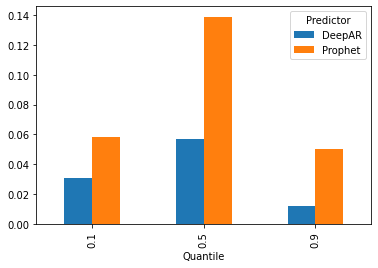

In [83]:
pd.concat([deep_ar_metrics, prophet_metrics]) \
    .pivot(index='Quantile', columns='Predictor', values='LossValue').plot.bar();

## Step 7. Create a Forecast

In [84]:
forecast_name_deep_ar = f"{PROJECT}_{DATA_VERSION}_deeparp"
print(f"Forecast Name = {forecast_name_deep_ar}")

Forecast Name = rossmann_store_sales_2_deeparp


In [85]:
create_forecast_response_deep_ar = forecast.create_forecast(ForecastName=forecast_name_deep_ar,
                                                        PredictorArn=predictor_arn_deep_ar)

In [86]:
forecast_arn_deep_ar = create_forecast_response_deep_ar['ForecastArn']

In [88]:
status = wait(lambda: forecast.describe_forecast(ForecastArn=forecast_arn_deep_ar))
assert status

CREATE_PENDING 
CREATE_IN_PROGRESS ...................................................................
ACTIVE 


In [93]:
forecast.describe_forecast(ForecastArn=forecast_arn_deep_ar)

{'ForecastArn': 'arn:aws:forecast:ap-south-1:843203996641:forecast/rossmann_store_sales_2_deeparp',
 'ForecastName': 'rossmann_store_sales_2_deeparp',
 'ForecastTypes': ['0.1', '0.5', '0.9'],
 'PredictorArn': 'arn:aws:forecast:ap-south-1:843203996641:predictor/rossmann_store_sales_2_deep_ar_plus',
 'DatasetGroupArn': 'arn:aws:forecast:ap-south-1:843203996641:dataset-group/rossmann_store_sales_2',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2021, 9, 21, 22, 34, 49, 353000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2021, 9, 21, 22, 46, 33, 670000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '5eb9decd-f36e-462c-a98a-7a4ebbd11d5f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 21 Sep 2021 17:20:22 GMT',
   'x-amzn-requestid': '5eb9decd-f36e-462c-a98a-7a4ebbd11d5f',
   'content-length': '473',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [94]:
forecast_name_prophet = f"{PROJECT}_{DATA_VERSION}_prophet"
print(f"Forecast Name = {forecast_name_prophet}")

Forecast Name = rossmann_store_sales_2_prophet


In [97]:
create_forecast_response_prophet = forecast.create_forecast(ForecastName=forecast_name_prophet,
                                                        PredictorArn=predictor_arn_prophet)

In [98]:
forecast_arn_prophet = create_forecast_response_prophet['ForecastArn']

In [99]:
status = wait(lambda: forecast.describe_forecast(ForecastArn=forecast_arn_prophet))
assert status

CREATE_PENDING .
CREATE_IN_PROGRESS ..............................................................
ACTIVE 


## Step 8. Query a Forecast

In [90]:
forecast_response_deep = forecastquery.query_forecast(
    ForecastArn=forecast_arn_deep_ar,
    Filters={"item_id": str(prim_store)})

In [100]:
forecast_response_prophet = forecastquery.query_forecast(ForecastArn=forecast_arn_prophet,
                                                     Filters={"item_id":str(prim_store)})

In [112]:
fname = f'./data/rossmann_store_{prim_store}_tts.csv'
exact = utils.load_exact_sol(fname, prim_store)
exact = exact[exact["timestamp"] > '2015-07-01']
exact.head()

,item_id,timestamp,target
0,262,2015-07-31,25774
1,262,2015-07-30,22253
2,262,2015-07-29,21041
3,262,2015-07-28,22442
4,262,2015-07-27,22185


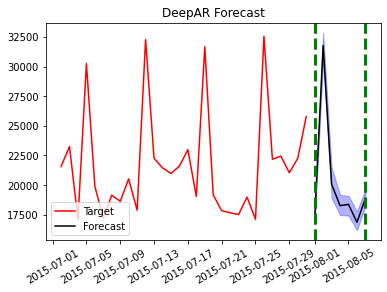

In [113]:
utils.plot_forecasts(forecast_response_deep, exact)
plt.title("DeepAR Forecast");

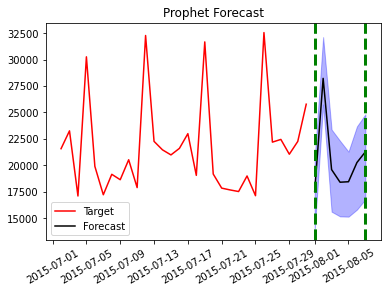

In [114]:
utils.plot_forecasts(forecast_response_prophet,exact)
plt.title("Prophet Forecast");

## Step 9. Export a Forecast

In [115]:
forecast_export_name_deep_ar = f"{PROJECT}_{DATA_VERSION}_forecast_export_deeparp"
forecast_export_name_deep_ar_path = f"{s3_data_path}/{forecast_export_name_deep_ar}"

In [116]:
create_forecast_export_response_deep_ar = \
    forecast.create_forecast_export_job(ForecastExportJobName=forecast_export_name_deep_ar,
                                        ForecastArn=forecast_arn_deep_ar,
                                        Destination={
                                            "S3Config" : {
                                                "Path": forecast_export_name_deep_ar_path,
                                                "RoleArn": role_arn
                                            }
                                        })
forecast_export_arn_deep_ar = create_forecast_export_response_deep_ar['ForecastExportJobArn']

In [117]:
forecast_export_name_prophet = f"{PROJECT}_{DATA_VERSION}_forecast_export_prophet"
forecast_export_name_prophet_path = f"{s3_data_path}/{forecast_export_name_prophet}"

In [118]:
create_forecast_export_response_prophet = \
    forecast.create_forecast_export_job(ForecastExportJobName=forecast_export_name_prophet,
                                        ForecastArn=forecast_arn_prophet,
                                        Destination={
                                            "S3Config" : {
                                                "Path": forecast_export_name_prophet_path,
                                                "RoleArn": role_arn
                                            }
                                        })
forecast_export_arn_prophet = create_forecast_export_response_prophet['ForecastExportJobArn']

## Step 10. Clean up your Resources